In [1]:
import tensorflow as tf
import os

In [2]:
#avoid OOM errors by setting GPU memory comsumption growth
#ensuring that not all the memory is used
gpus=tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [3]:
tf.config.list_physical_devices('GPU')

[]

remove dodgy images


In [4]:
import cv2
import imghdr

C:\Users\Arushi\AppData\Local\Temp\ipykernel_25116\4232469594.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [5]:
data_dir='0 FaceImages'

In [6]:
image_exts=['jpeg','jpg','bmp','png']

In [7]:
image_exts

['jpeg', 'jpg', 'bmp', 'png']

In [8]:
# plt.imshow(img)
# to chage from bgr to rgb
# plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [9]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

LOAD DATA

In [10]:
import numpy as np
from matplotlib import pyplot as plt

In [11]:
data = tf.keras.utils.image_dataset_from_directory(
    '0 FaceImages'
)# make a data pipeline

Found 9120 files belonging to 2 classes.


In [12]:
class_names = data.class_names
print(class_names)

['Active Subjects', 'Fatigue Subjects']


In [13]:
data_iterator=data.as_numpy_iterator()
# easier access to data pipeline

In [14]:
batch=data_iterator.next()
# loop through data pipeline

In [15]:
# 0 for closed
# 1 for open
batch[1]
#batch[0]==image as an array
#batch[1]==label of the image

array([1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 1, 1, 0])

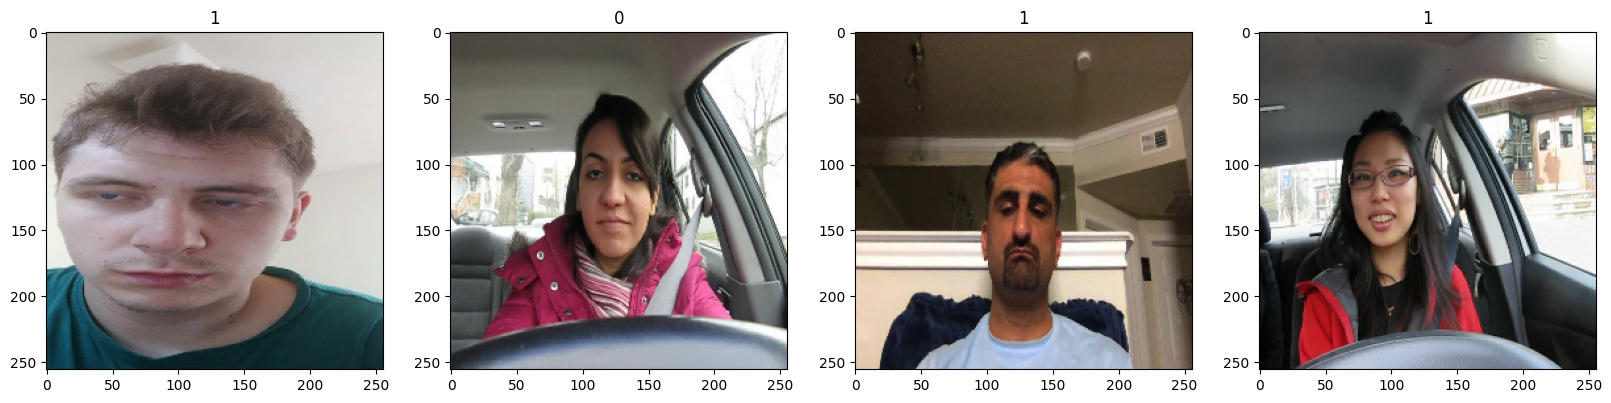

In [16]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

<h3>PREPROCESSING DATA</h3>
<hr>
<p>converting values of images between 0 and 1 instead of 0 to 255 (optimization)</p>
<p>and also splitting the data into training, testing and validation partiton to ensure that we dont overfit</p>

In [17]:
data=data.map(lambda x, y: (x/255, y))

In [18]:
scaled_it=data.as_numpy_iterator()

In [19]:
batch=scaled_it.next()

In [20]:
batch[0].min()

0.0

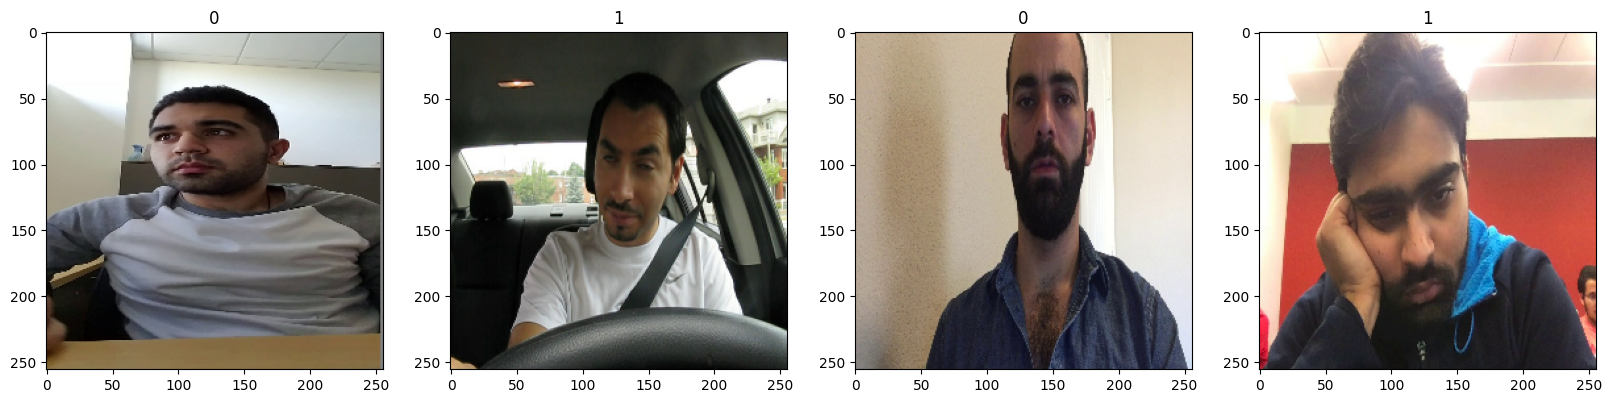

In [21]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

split data

In [22]:
train_size=int(len(data)*0.7)
val_size=int(len(data)*0.2)
test_size=int(len(data)*0.1)+1

In [23]:
train=data.take(train_size)
val=data.skip(train_size).take(val_size)
test=data.skip(train_size+val_size).take(test_size)

DEEP LEARNING MODEL <hr>
using keras sequential api

In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [51]:
model=Sequential()

In [52]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(64, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [53]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [54]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 254, 254, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 127, 127, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 125, 125, 64)        │           9,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 60, 60, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 30, 30, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 28800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       7,373,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,401,505 (28.23 MB)

 Trainable params: 7,401,505 (28.23 MB)

 Non-trainable params: 0 (0.00 B)

train

In [55]:
logdir='log'

In [56]:
tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [57]:
hist=model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 123s 585ms/step - accuracy: 0.7153 - loss: 0.6011 - val_accuracy: 0.8459 - val_loss: 0.3654
Epoch 2/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 109s 545ms/step - accuracy: 0.8410 - loss: 0.3550 - val_accuracy: 0.8531 - val_loss: 0.3457
Epoch 3/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 138s 694ms/step - accuracy: 0.8581 - loss: 0.3087 - val_accuracy: 0.8470 - val_loss: 0.3665
Epoch 4/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 134s 667ms/step - accuracy: 0.8739 - loss: 0.2856 - val_accuracy: 0.8668 - val_loss: 0.3360
Epoch 5/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 134s 671ms/step - accuracy: 0.8863 - loss: 0.2616 - val_accuracy: 0.8712 - val_loss: 0.3439
Epoch 6/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 130s 652ms/step - accuracy: 0.8985 - loss: 0.2472 - val_accuracy: 0.8717 - val_loss: 0.3341
Epoch 7/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 133s 665ms/step - accuracy: 0.9051 - loss: 0.2216 - val_accuracy: 0.8723 - val_loss: 0.3338
Epoch 8/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 132s 658ms/step - accuracy: 0.9089 -

PLOT PERFORMANCE

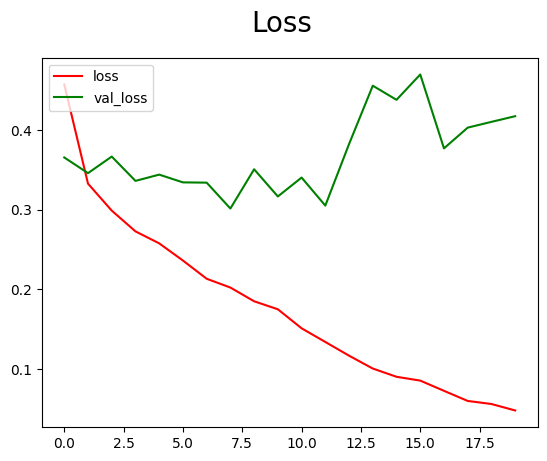

In [58]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='red', label='loss')
plt.plot(hist.history['val_loss'], color='green', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

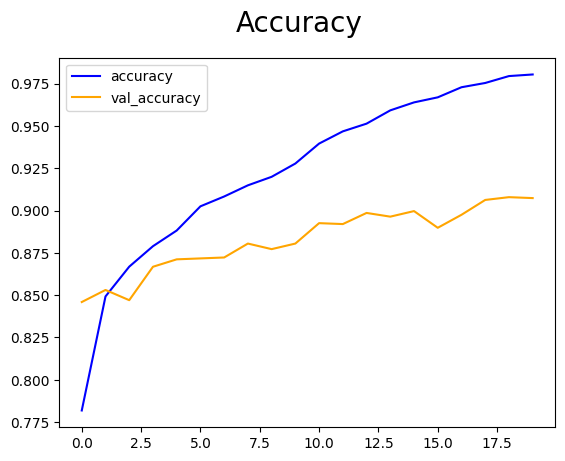

In [59]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='blue', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

EVALUATE
<hr>
precision, recall and accuracy

In [60]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [61]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()


In [62]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [63]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision:0.9111111164093018, Recall:0.8686440587043762, Accuracy:0.8900862336158752


In [64]:
!pip install numpy matplotlib seaborn scikit-learn
print('the new from gpt')


the new from gpt



[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

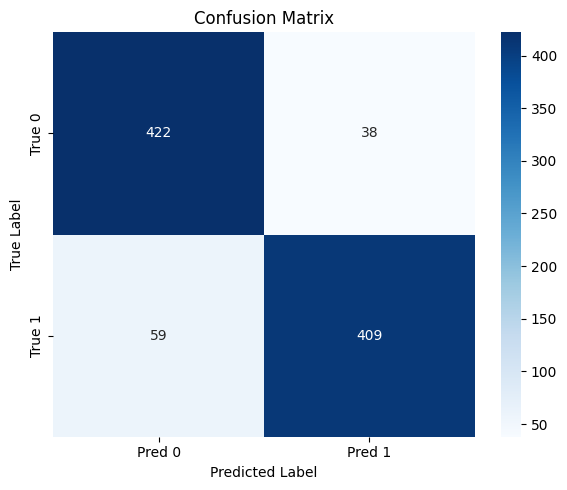

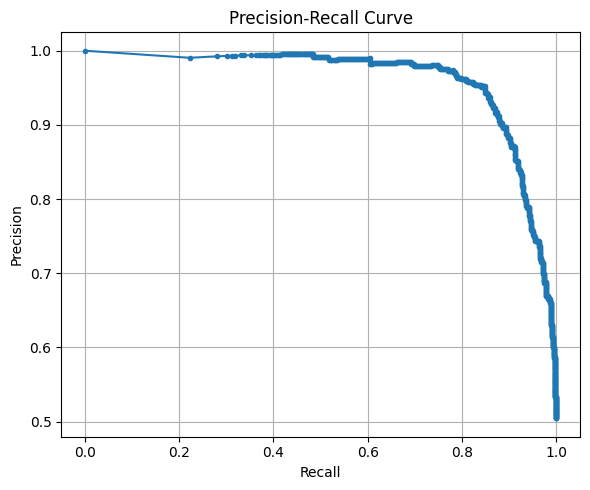

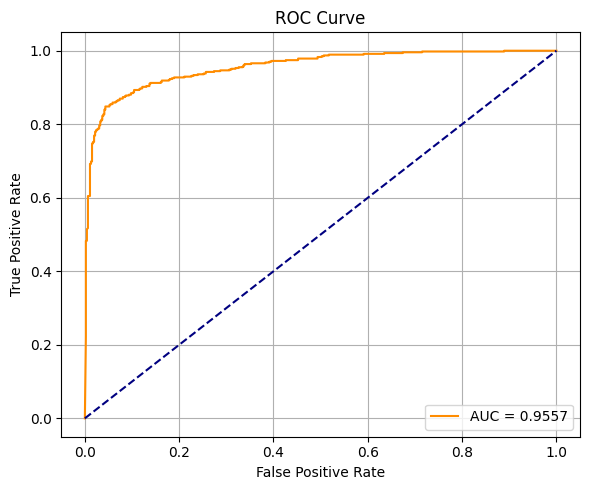

C:\Users\Arushi\AppData\Local\Temp\ipykernel_25116\3667087018.py:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=values, palette='mako')


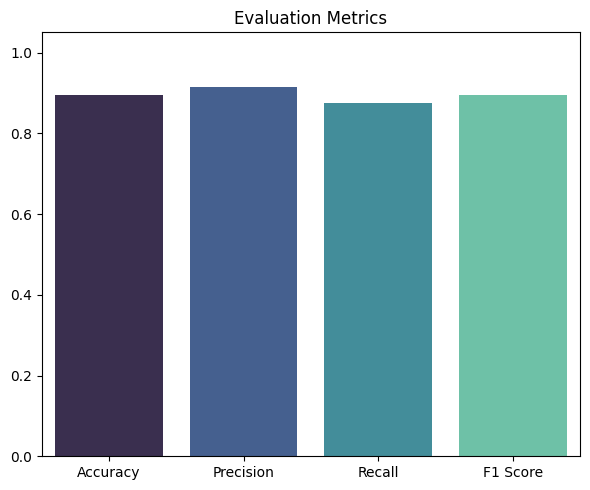

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    precision_score, recall_score, accuracy_score,
    f1_score, confusion_matrix, precision_recall_curve,
    roc_curve, auc
)

# ------------------- Collect predictions and true labels -------------------
y_true = []
y_pred = []
y_prob = []  # Probabilities for PR and ROC curves

for batch in test.as_numpy_iterator():
    X, y = batch
    probs = model.predict(X).flatten()
    preds = (probs > 0.5).astype(int)

    y_true.extend(y.flatten())
    y_pred.extend(preds)
    y_prob.extend(probs)

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)

# ------------------- Compute metrics -------------------
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)

# ------------------- Print metrics -------------------
print(f"Accuracy  : {accuracy:.4f}")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1 Score  : {f1:.4f}")
print("Confusion Matrix:")
print(cm)

# ------------------- Plot 1: Confusion Matrix -------------------
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Pred 0", "Pred 1"], yticklabels=["True 0", "True 1"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# ------------------- Plot 2: Precision-Recall Curve -------------------
precision_vals, recall_vals, _ = precision_recall_curve(y_true, y_prob)

plt.figure(figsize=(6, 5))
plt.plot(recall_vals, precision_vals, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.tight_layout()
plt.show()

# ------------------- Plot 3: ROC Curve -------------------
fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# ------------------- Plot 4: Bar Chart of Metrics -------------------
plt.figure(figsize=(6, 5))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [accuracy, precision, recall, f1]
sns.barplot(x=metrics, y=values, palette='mako')
plt.ylim(0, 1.05)
plt.title('Evaluation Metrics')
plt.tight_layout()
plt.show()

TEST

saving the model

In [66]:
from tensorflow.keras.models import load_model

In [67]:
model.save(os.path.join('models','drowsy.h5'))

In [68]:
new_model = load_model(os.path.join('models','drowsy.h5'))